# Mahcine Learning Project

Ruiyang Zhou 662005044

## 数据处理 Image Process

In [17]:
import json
from PIL import Image, ImageDraw
import numpy as np
import os

annotations_path = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/train/_annotations.coco.json'
images_dir = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/train'

with open(annotations_path, 'r') as f:
    coco_data = json.load(f)

for image_info in coco_data['images']:
    # Create Mask
    mask = Image.new('L', (image_info['width'], image_info['height']), 0)
    draw = ImageDraw.Draw(mask)

    # Find all images' matched annotation
    image_annotations = [anno for anno in coco_data['annotations'] if anno['image_id'] == image_info['id']]

    for anno in image_annotations:
        if 'segmentation' in anno:
            for segmentation in anno['segmentation']:
                draw.polygon(segmentation, outline=255, fill=255)

    image_path = os.path.join(images_dir, image_info['file_name'])

    # Error check
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        print(f"文件未找到: {image_path}")
        continue

    # File saving
    mask_save_path = os.path.join('/content/drive/MyDrive/sample/Floor Detection.v2i.coco', 'masks', image_info['file_name'].replace('.jpg', '_mask.png'))
    os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
    mask.save(mask_save_path)

    print(f"处理并保存了图片和蒙版：{image_info['file_name']}")  # Processed and saved images and masks



处理并保存了图片和蒙版：9_kitchen_jpg.rf.e4716f6cda028d22b6be08b5a4dae573.jpg
处理并保存了图片和蒙版：319_jpg.rf.d7a9db487cdcb27c922b9a2c3849084f.jpg
处理并保存了图片和蒙版：330_jpg.rf.d70b4c217afb4b744bce3bef8f71ea75.jpg
处理并保存了图片和蒙版：334_jpg.rf.d629fbf31a427441d7acda938290ea7a.jpg
处理并保存了图片和蒙版：111_jpg.rf.d268a1a4b314ea6a05b646c6565fbb11.jpg
处理并保存了图片和蒙版：46_jpg.rf.e1fa5c83ded1d373d290e7b6aa3ed59c.jpg
处理并保存了图片和蒙版：25_jpg.rf.e462c36ad1f1729989ccc09dd18da72e.jpg
处理并保存了图片和蒙版：318_jpg.rf.e17f49120121ecc26a048eb9ef13bffc.jpg
处理并保存了图片和蒙版：170_jpg.rf.e1099da169338430dc593de2f4a3f403.jpg
处理并保存了图片和蒙版：95_jpg.rf.d597e59a9b1902d6e701a09716514ba1.jpg
处理并保存了图片和蒙版：37_jpg.rf.e138f109bdfb5310e19a3ffc7caa5a7e.jpg
处理并保存了图片和蒙版：302_jpg.rf.d663789f661069fc4f6e2310141be126.jpg
处理并保存了图片和蒙版：18_bedroom_jpg.rf.d8c78120297406849fd04037eb139cc1.jpg
处理并保存了图片和蒙版：30_jpg.rf.dfbdbae52ed366f8de05544d7e676b8e.jpg
处理并保存了图片和蒙版：312_jpg.rf.e4592728a5eb4ff1a1fcea5076deede7.jpg
处理并保存了图片和蒙版：3_kitchen_jpg.rf.e5af21b03f05e8bbd182667920c483f6.jpg
处理并保存了图片和蒙版：117_jpg.rf.d56

## 图像预处理 Image Arrange

In [67]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image, ImageOps

def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    """
    加载并调整图像及其对应蒙版的大小，确保图像正确处理旋转，并归一化。
    """
    image = load_img(image_path)
    image = ImageOps.exif_transpose(image)
    image = img_to_array(image.resize(target_size, Image.Resampling.LANCZOS)) / 255.0

    mask = load_img(mask_path, color_mode='grayscale')
    mask = img_to_array(mask.resize(target_size, Image.Resampling.NEAREST)) / 255.0
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

def load_dataset(image_dir, mask_dir, target_size=(256, 256)):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        # Skip Error
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace(".jpg", "_mask.png"))

        if not os.path.exists(mask_path):
            print(f"Mask file not found for {filename}, skipping.")
            continue

        image, mask = load_image_and_mask(image_path, mask_path, target_size)
        images.append(image)
        masks.append(mask[:,:,0])  # 3D

    return np.array(images), np.array(masks)


# Data generator
def get_data_generators(X_train, Y_train, X_val, Y_val, batch_size=32):
    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_datagen.fit(X_train, augment=True, seed=42)
    mask_datagen.fit(Y_train, augment=True, seed=42)

    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(Y_train, batch_size=batch_size, seed=42)

    train_generator = zip(image_generator, mask_generator)

    val_generator = (X_val, Y_val)

    return train_generator, val_generator

image_dir = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/train'
mask_dir = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/masks_train'

try:
    X, Y = load_dataset(image_dir, mask_dir)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)
    train_generator, val_generator = get_data_generators(X_train, Y_train, X_val, Y_val)
except FileNotFoundError as e:
    print(e)
    print("请检查您的文件路径是否正确，并确保所有文件都存在。")   # Error Check




## 模型训练 Model Training

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def build_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # 编码器部分
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    # 解码器部分
    up4 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge4 = concatenate([conv4, up4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge3 = concatenate([conv3, up3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge2 = concatenate([conv2, up2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge1 = concatenate([conv1, up1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_36 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_35[0][0]']           
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_36[0][0]']           
 g2D)                                                                                       

In [70]:
results = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=40,
    validation_steps=5,
    epochs=30
)



Epoch 1/30
40/40 [==============================] - 89s 2s/step - loss: 0.4394 - accuracy: 0.8502 - val_loss: 0.3783 - val_accuracy: 0.8413
Epoch 2/30
40/40 [==============================] - 49s 1s/step - loss: 0.3088 - accuracy: 0.8544 - val_loss: 0.3060 - val_accuracy: 0.8582
Epoch 3/30
40/40 [==============================] - 48s 1s/step - loss: 0.2689 - accuracy: 0.8644 - val_loss: 0.2726 - val_accuracy: 0.8658
Epoch 4/30
40/40 [==============================] - 50s 1s/step - loss: 0.2453 - accuracy: 0.8743 - val_loss: 0.2782 - val_accuracy: 0.8702
Epoch 5/30
40/40 [==============================] - 48s 1s/step - loss: 0.2388 - accuracy: 0.8760 - val_loss: 0.2725 - val_accuracy: 0.8592
Epoch 6/30
40/40 [==============================] - 48s 1s/step - loss: 0.2346 - accuracy: 0.8796 - val_loss: 0.2702 - val_accuracy: 0.8696
Epoch 7/30
40/40 [==============================] - 48s 1s/step - loss: 0.2213 - accuracy: 0.8860 - val_loss: 0.2702 - val_accuracy: 0.8727
Epoch 8/30
40/40 [==

In [71]:

test_loss, test_acc = model.evaluate(X, Y)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")


9/9 [==============================] - 4s 380ms/step - loss: 0.1706 - accuracy: 0.9318
Test loss: 0.1705888956785202, Test accuracy: 0.9318363666534424
3/3 [==============================] - 4s 2s/step - loss: 0.2616 - accuracy: 0.9023
Validation loss: 0.26158633828163147, Validation accuracy: 0.9023160338401794


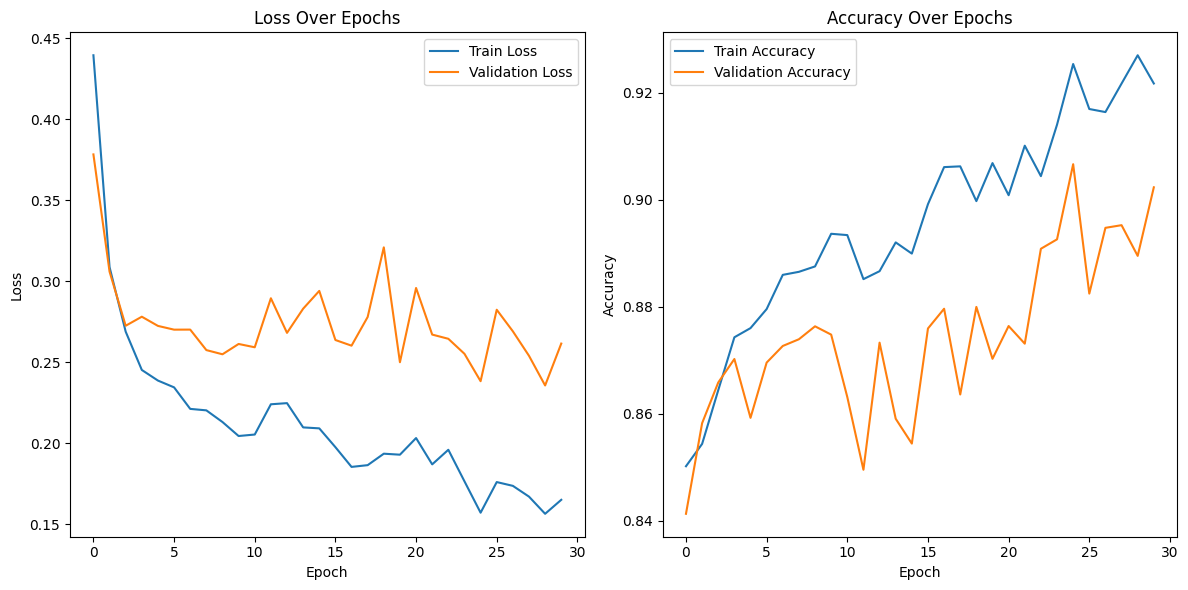

In [72]:
import matplotlib.pyplot as plt


history = results.history

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 测试 Test

1/1 [==============================] - 0s 218ms/step


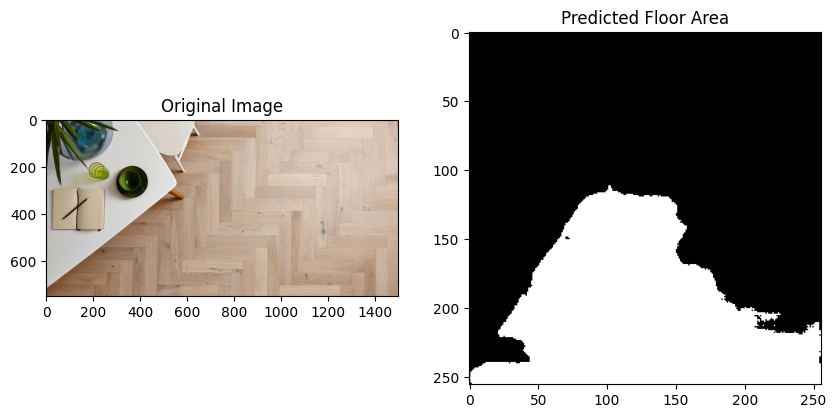

In [73]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image

# Load Image
image_path = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/test_websource/test3.jpg'
image = load_img(image_path, target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.0

prediction = model.predict(image)

import matplotlib.pyplot as plt


predicted_mask = prediction[0]
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Original Image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(load_img(image_path))


plt.subplot(1, 2, 2)
plt.title("Predicted Floor Area")
plt.imshow(predicted_mask[:, :, 0], cmap='gray')

plt.show()


1/1 [==============================] - 0s 19ms/step


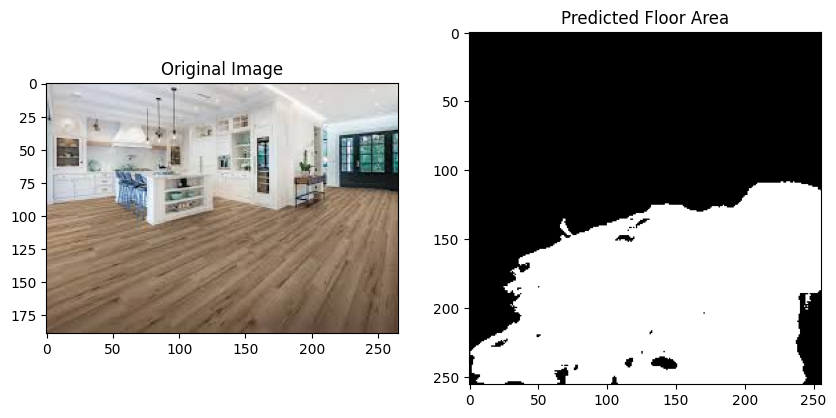

In [74]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image

# Load Image
image_path = '/content/drive/MyDrive/sample/Floor Detection.v2i.coco/test_websource/test1.jpg'
image = load_img(image_path, target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.0

prediction = model.predict(image)

import matplotlib.pyplot as plt


predicted_mask = prediction[0]
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Original Image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(load_img(image_path))


plt.subplot(1, 2, 2)
plt.title("Predicted Floor Area")
plt.imshow(predicted_mask[:, :, 0], cmap='gray')

plt.show()


## Reference

In [30]:
@misc{
                        	floor-detection-btxc3_dataset,
                        	title = { Floor Detection Dataset },
                        	type = { Open Source Dataset },
                        	author = { SavelyZh },
                        	howpublished = { \url{ https://universe.roboflow.com/savelyzh-bn3gq/floor-detection-btxc3 } },
                        	url = { https://universe.roboflow.com/savelyzh-bn3gq/floor-detection-btxc3 },
                        	journal = { Roboflow Universe },
                        	publisher = { Roboflow },
                        	year = { 2023 },
                        	month = { aug },
                        	note = { visited on 2024-04-16 },
                        	}

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-30-6eb7fefbb5c6>, line 3)